In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.types import * 
from pyspark.sql.functions import lit
import pyodbc
import pandas as pd
import pyspark.sql.functions as sf
from pyspark.context import SparkContext


In [2]:
import findspark
findspark.init()


In [3]:
spark = SparkSession.builder.config("spark.driver.memory", "15g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/29 08:51:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
def process_log_data(path,file_name,date):
    df = spark.read.json(path+file_name)
    df = df.select('_source.AppName','_source.Contract','_source.Mac','_source.TotalDuration')
    df = df.withColumn('Date',lit(date))
    df = df.withColumn('Type',
                 when((col("AppName") == 'CHANNEL') | (col("AppName") =='DSHD')| (col("AppName") =='KPLUS')| (col("AppName") =='KPlus'), "Dramas")
          .when((col("AppName") == 'VOD') | (col("AppName") =='FIMS_RES')| (col("AppName") =='BHD_RES')| 
                 (col("AppName") =='VOD_RES')| (col("AppName") =='FIMS')| (col("AppName") =='BHD')| (col("AppName") =='DANET'), "TV Shows")
          .when((col("AppName") == 'RELAX'), "Entertainment")
          .when((col("AppName") == 'CHILD'), "Kids")
          .when((col("AppName") == 'SPORT'), "Sports")
          .otherwise("Error"))
    df = df.select('Contract','Type','TotalDuration','Date')
    df = df.groupBy('Contract','Type','Date').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')
    return df 

In [5]:
def main_task():
    path="/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/"
    df = process_log_data(path,"20220401.json",'2022-04-01')
    for i in range(2,31):
        day = ("{:02d}".format(i))
        filename = '202204{}.json'.format(day)
        date = '2022-04-{}'.format(day)
        df1 = process_log_data(path,filename, date)
        df = df.union(df1)
    return df

In [6]:
def process_daily_statistics(df):
    daily_statistic = df.groupBy('Date','Type').agg({'TotalDuration':'sum','Contract':'count'}).withColumnRenamed('sum(TotalDuration)','TotalDuration').withColumnRenamed('count(Contract)','TotalUsers')
    daily_statistic = daily_statistic.withColumn('TotalDuration',col('TotalDuration')/3600)
    return daily_statistic
    

In [7]:
df = main_task() 
df = df.cache()
df.count()

42010590

In [8]:
df.show()

+---------+--------+----------+-------------+
| Contract|    Type|      Date|TotalDuration|
+---------+--------+----------+-------------+
|TGFD20318|  Dramas|2022-04-01|        84056|
|BNFD55622|  Dramas|2022-04-01|         4968|
|TVAAA0290|TV Shows|2022-04-01|         4153|
|NTD035685|TV Shows|2022-04-01|            0|
|HNH815050|TV Shows|2022-04-01|        15684|
|TQFD01800|  Dramas|2022-04-01|        89152|
|THFD12339|TV Shows|2022-04-01|        82473|
|CTFD22053|TV Shows|2022-04-01|        20990|
|VPFD10186|TV Shows|2022-04-01|         2953|
|HNH385936|  Dramas|2022-04-01|        18885|
|SGH043105|TV Shows|2022-04-01|        10273|
|HDFD45530|  Dramas|2022-04-01|        82435|
|HNH411694|  Dramas|2022-04-01|        54048|
|HNH921243|TV Shows|2022-04-01|         4436|
|SGH918630|  Dramas|2022-04-01|           38|
|SGD406054|TV Shows|2022-04-01|        10107|
|SLFD02698|  Dramas|2022-04-01|       131614|
|HNH003269|TV Shows|2022-04-01|         9486|
|SGH955709|TV Shows|2022-04-01|   

## Data Checking

In [9]:
df.select('Date').distinct().count()

30

In [10]:
df.filter(df.TotalDuration.isNull()).show() ##Check if any null variables

+--------+-----+----------+-------------+
|Contract| Type|      Date|TotalDuration|
+--------+-----+----------+-------------+
|    null|Error|2022-04-08|         null|
+--------+-----+----------+-------------+



In [11]:
df.filter(df.Contract.isNull()).show() ##Check if any null variables

+--------+-----+----------+-------------+
|Contract| Type|      Date|TotalDuration|
+--------+-----+----------+-------------+
|    null|Error|2022-04-08|         null|
+--------+-----+----------+-------------+



In [12]:
df = df.dropna(how="any")
df.show(truncate=False)

+---------+--------+----------+-------------+
|Contract |Type    |Date      |TotalDuration|
+---------+--------+----------+-------------+
|TGFD20318|Dramas  |2022-04-01|84056        |
|BNFD55622|Dramas  |2022-04-01|4968         |
|TVAAA0290|TV Shows|2022-04-01|4153         |
|NTD035685|TV Shows|2022-04-01|0            |
|HNH815050|TV Shows|2022-04-01|15684        |
|TQFD01800|Dramas  |2022-04-01|89152        |
|THFD12339|TV Shows|2022-04-01|82473        |
|CTFD22053|TV Shows|2022-04-01|20990        |
|VPFD10186|TV Shows|2022-04-01|2953         |
|HNH385936|Dramas  |2022-04-01|18885        |
|SGH043105|TV Shows|2022-04-01|10273        |
|HDFD45530|Dramas  |2022-04-01|82435        |
|HNH411694|Dramas  |2022-04-01|54048        |
|HNH921243|TV Shows|2022-04-01|4436         |
|SGH918630|Dramas  |2022-04-01|38           |
|SGD406054|TV Shows|2022-04-01|10107        |
|SLFD02698|Dramas  |2022-04-01|131614       |
|HNH003269|TV Shows|2022-04-01|9486         |
|SGH955709|TV Shows|2022-04-01|137

In [13]:
df.filter(df.Contract.isNull()).show()

+--------+----+----+-------------+
|Contract|Type|Date|TotalDuration|
+--------+----+----+-------------+
+--------+----+----+-------------+



In [14]:
daily_statistic = process_daily_statistics(df)

In [15]:
df.repartition(1).write.csv('/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/DF_Clean',header=True)

In [16]:
daily_statistic.repartition(1).write.csv('/Users/quynhnguyen/Documents/DA classes/Big Data/Dataset/Daily_Statistic',header=True)

## Descriptive Statistic daily

In [17]:
visual_1 = daily_statistic.toPandas()

In [18]:
visual_1 = visual_1.sort_values(by = 'Date', ascending = True)

In [19]:
visual_1.head()

,Date,Type,TotalUsers,TotalDuration
0,2022-04-01,Sports,2292,3.239550e+02
54,2022-04-01,Dramas,1355367,7.002872e+06
55,2022-04-01,Kids,33056,4.960283e+04
53,2022-04-01,TV Shows,86312,1.742085e+05
52,2022-04-01,Entertainment,6394,5.807752e+03


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

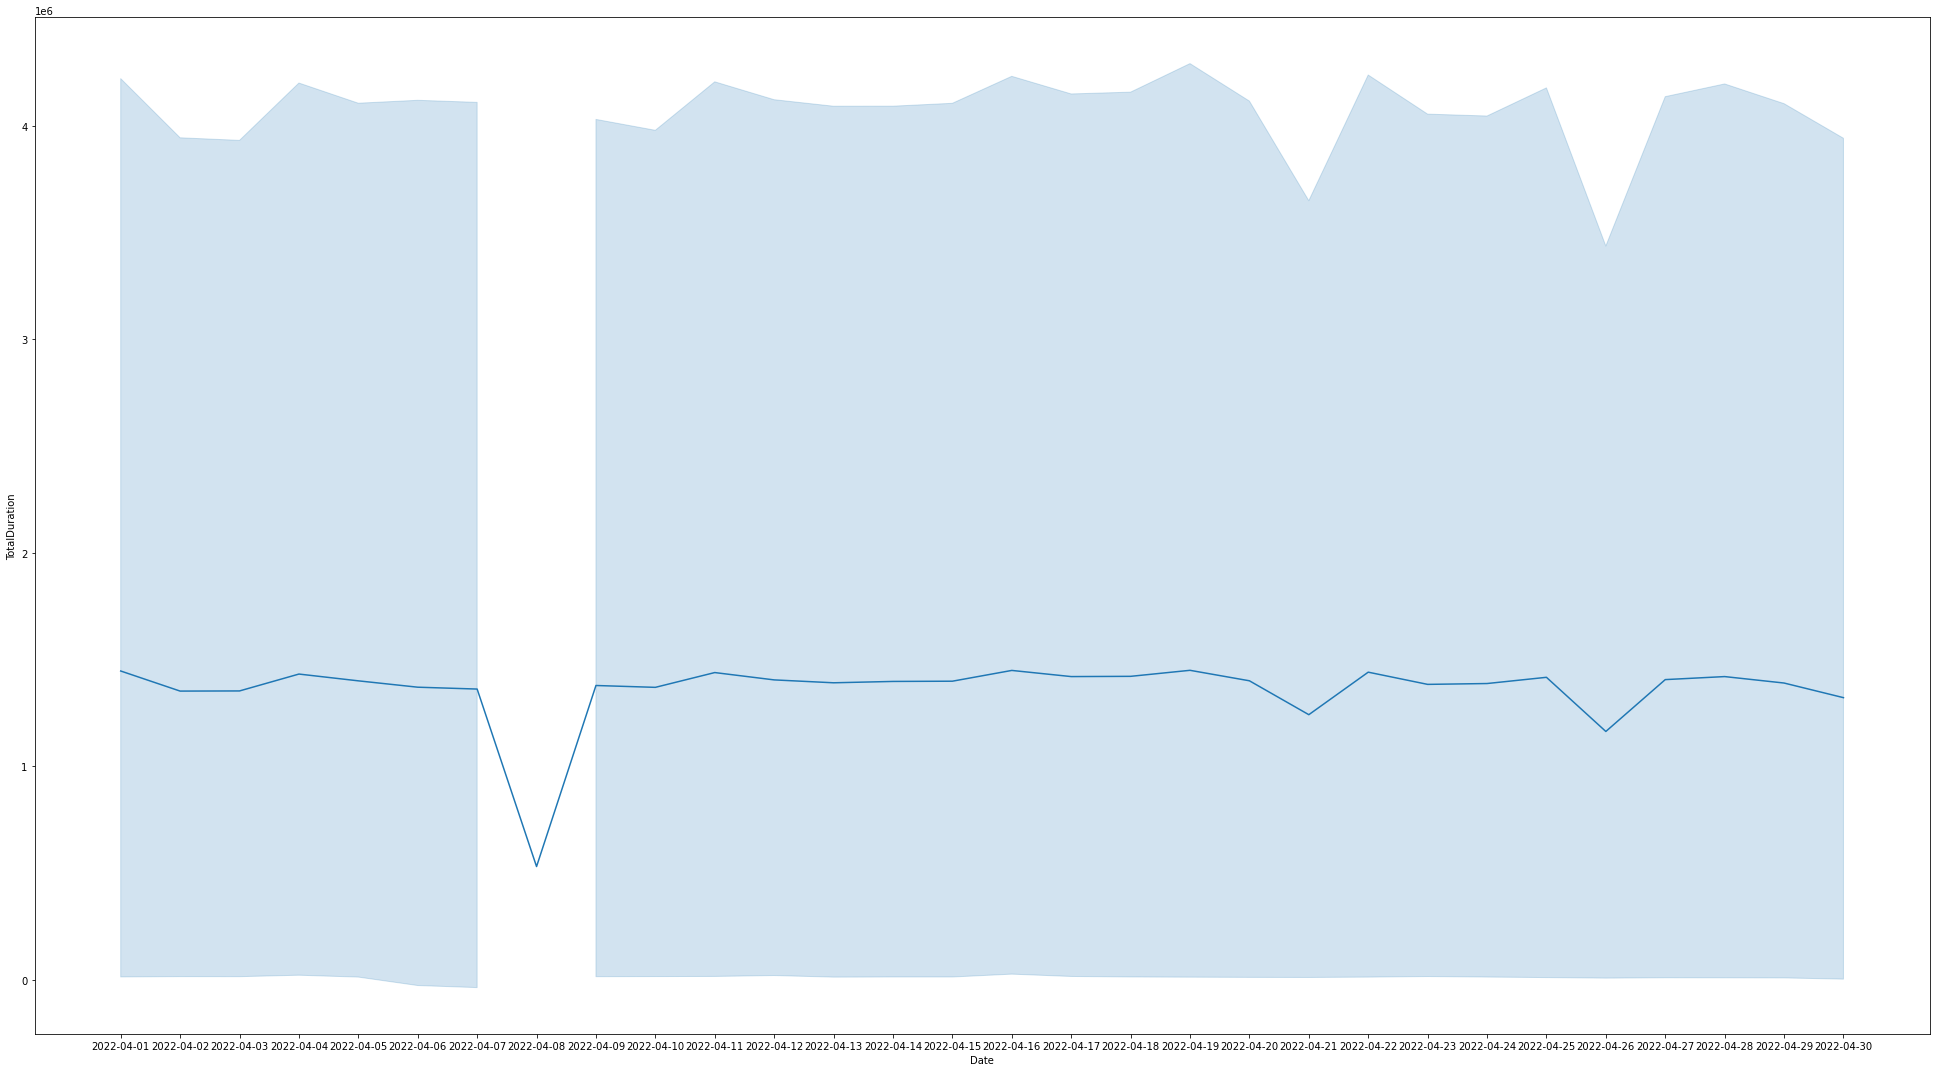

In [21]:
plt.figure(figsize=(27, 15))
sns.lineplot(x = 'Date', y ='TotalDuration', data = visual_1)
plt.tight_layout()

<AxesSubplot:xlabel='Date', ylabel='TotalDuration'>

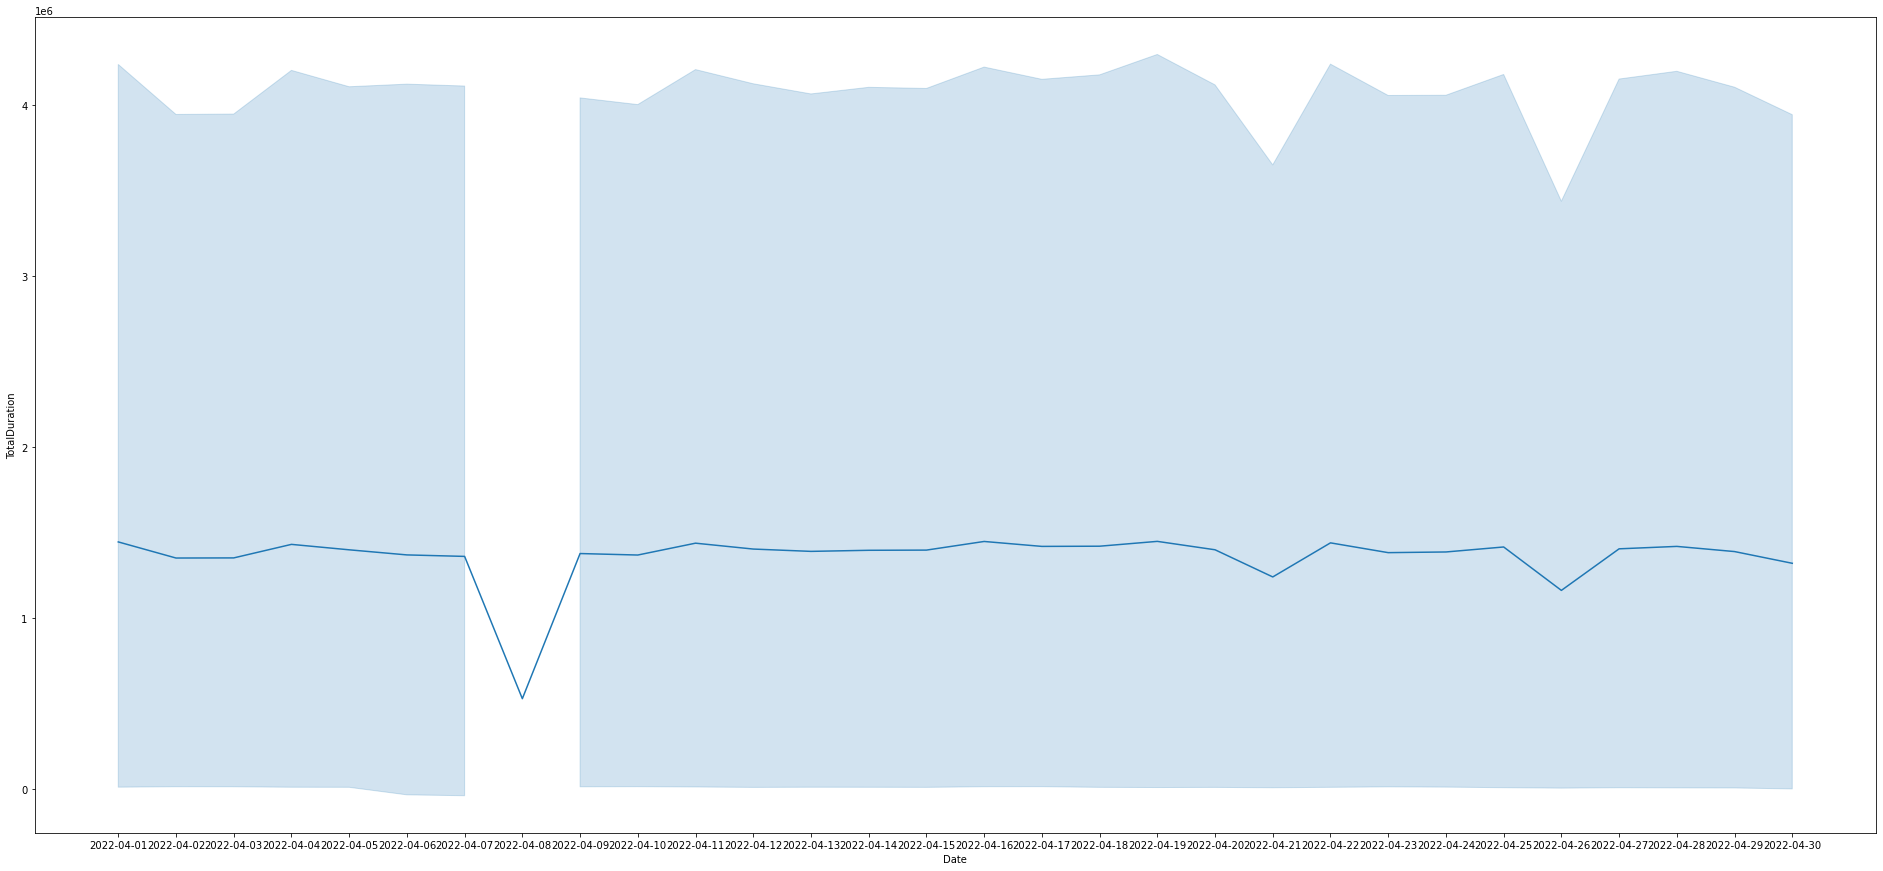

In [22]:
plt.figure(figsize=(33, 15))
sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalDuration')

In [23]:
df.count()

42010589

In [24]:
df.select('Contract').count()

42010589

In [25]:
df.select('Contract').distinct().count()

1918176

## Individual Customer Statistics

In [26]:
df.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- Type: string (nullable = false)
 |-- Date: string (nullable = false)
 |-- TotalDuration: long (nullable = true)



In [27]:
df = df.drop('Date')

In [28]:
df = df.groupBy('Contract','Type').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')

In [29]:
df.show()

+---------+--------+-------------+
| Contract|    Type|TotalDuration|
+---------+--------+-------------+
|LAFDN0001|  Dramas|      1671609|
|VPFD01775|  Dramas|       317524|
|HNH341944|  Dramas|         4539|
|HNJ100781|TV Shows|        97437|
|HUFD03958|TV Shows|        20651|
|HNH969358|  Dramas|       119251|
|HNH720861|  Dramas|       657424|
|BDFD75415|  Dramas|       960198|
|NDFD02966|  Dramas|       893383|
|DAFD54866|  Dramas|       757721|
|BDFD19617|  Dramas|        60407|
|TQFD19300|  Dramas|       121870|
|SGD807739|  Dramas|       130803|
|NTD041955|  Dramas|       100356|
|TBFD30384|  Dramas|        71831|
|HPFD78662|  Dramas|       533630|
|SGH860251|  Dramas|      1172207|
|NDAAA2507|  Dramas|       193008|
|SGH656775|  Dramas|      1498866|
|CTFD35307|  Dramas|       174508|
+---------+--------+-------------+
only showing top 20 rows



In [30]:
df.select('Type').distinct().show()

+-------------+
|         Type|
+-------------+
|     TV Shows|
|Entertainment|
|       Sports|
|       Dramas|
|         Kids|
|        Error|
+-------------+



In [31]:
df = df.filter(df.Type != 'Error')

In [32]:
df.select('Type').distinct().show()

+-------------+
|         Type|
+-------------+
|     TV Shows|
|Entertainment|
|       Sports|
|       Dramas|
|         Kids|
+-------------+



In [33]:
TVshows = df.filter(df.Type == 'TV Shows')
Sport = df.filter(df.Type == 'Sports')
Kids = df.filter(df.Type == 'Kids')
Entertainment = df.filter(df.Type == 'Entertainment')
Movie = df.filter(df.Type == 'Dramas')

In [34]:
TVshows = TVshows.drop('Type').withColumnRenamed('TotalDuration','TVDuration')
Sport = Sport.drop('Type').withColumnRenamed('TotalDuration','SportDuration')
Kids = Kids.drop('Type').withColumnRenamed('TotalDuration','KidsDuration')
Entertainment = Entertainment.drop('Type').withColumnRenamed('TotalDuration','EntertainmentDuration')
Movie = Movie.drop('Type').withColumnRenamed('TotalDuration','MovieDuration')

In [35]:
result = TVshows.join(Sport, ['Contract'], how='full').join(Movie,['Contract'],how ='full').join(Kids,['Contract'],how ='full').join(Entertainment,['Contract'],how ='full')

In [36]:
result.show()

+--------------+----------+-------------+-------------+------------+--------------------+
|      Contract|TVDuration|SportDuration|MovieDuration|KidsDuration|Entertainmenturation|
+--------------+----------+-------------+-------------+------------+--------------------+
|113.182.209.48|      null|         null|           63|        null|                  89|
|14.182.110.125|      null|         null|          404|        null|                  92|
|     AGAAA0338|      null|         null|       267694|        null|                null|
|     AGAAA0342|      null|         null|       117788|        null|                 204|
|     AGAAA0346|      null|         null|      2012371|        null|                null|
|     AGAAA0353|      1665|         null|        25749|        null|                null|
|     AGAAA0372|      null|         null|        13123|        null|                null|
|     AGAAA0391|       129|         null|       158931|        null|                 373|
|     AGAA

In [37]:
result.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- TVDuration: long (nullable = true)
 |-- SportDuration: long (nullable = true)
 |-- MovieDuration: long (nullable = true)
 |-- KidsDuration: long (nullable = true)
 |-- Entertainmenturation: long (nullable = true)



In [38]:
result.coalesce(1).write.option("header", "true").csv("T4Duration.csv")

In [39]:
result.count()

1918176

In [41]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank
from pyspark.sql.functions import col 

In [42]:
window = Window.partitionBy('Contract').orderBy(col('TotalDuration').desc())

In [43]:
rank_result = df.withColumn('RANK', rank().over(window))

In [44]:
rank_result.show()

+--------------+-------------+-------------+----+
|      Contract|         Type|TotalDuration|RANK|
+--------------+-------------+-------------+----+
|113.182.209.48|Entertainment|           89|   1|
|113.182.209.48|       Dramas|           63|   2|
|14.182.110.125|       Dramas|          404|   1|
|14.182.110.125|Entertainment|           92|   2|
|14.189.124.168|       Dramas|          147|   1|
|     AGAAA0338|       Dramas|       267694|   1|
|     AGAAA0342|       Dramas|       117788|   1|
|     AGAAA0342|Entertainment|          204|   2|
|     AGAAA0346|       Dramas|      2012371|   1|
|     AGAAA0353|       Dramas|        25749|   1|
|     AGAAA0353|     TV Shows|         1665|   2|
|     AGAAA0372|       Dramas|        13123|   1|
|     AGAAA0391|       Dramas|       158931|   1|
|     AGAAA0391|Entertainment|          373|   2|
|     AGAAA0391|     TV Shows|          129|   3|
|     AGAAA0452|       Dramas|        29764|   1|
|     AGAAA0504|       Dramas|        21299|   1|


In [45]:
most_watched = rank_result.filter(rank_result.RANK == '1')

In [46]:
most_watched.show()

+--------------+-------------+-------------+----+
|      Contract|         Type|TotalDuration|RANK|
+--------------+-------------+-------------+----+
|113.182.209.48|Entertainment|           89|   1|
|14.182.110.125|       Dramas|          404|   1|
|14.189.124.168|       Dramas|          147|   1|
|     AGAAA0338|       Dramas|       267694|   1|
|     AGAAA0342|       Dramas|       117788|   1|
|     AGAAA0346|       Dramas|      2012371|   1|
|     AGAAA0353|       Dramas|        25749|   1|
|     AGAAA0372|       Dramas|        13123|   1|
|     AGAAA0391|       Dramas|       158931|   1|
|     AGAAA0452|       Dramas|        29764|   1|
|     AGAAA0504|       Dramas|        21299|   1|
|     AGAAA0544|       Dramas|       155577|   1|
|     AGAAA0550|       Dramas|      2129475|   1|
|     AGAAA0555|       Dramas|       342362|   1|
|     AGAAA0576|       Dramas|       727679|   1|
|     AGAAA0593|       Dramas|         1038|   1|
|     AGAAA0608|       Dramas|         2129|   1|


In [47]:
most_watched = most_watched.drop('TotalDuration', 'RANK').withColumnRenamed('Type', 'Most Watch')

In [48]:
habit = result.join(most_watched, ['Contract'], how = 'inner')

In [49]:
habit.show()

+--------------+----------+-------------+-------------+------------+--------------------+-------------+
|      Contract|TVDuration|SportDuration|MovieDuration|KidsDuration|Entertainmenturation|   Most Watch|
+--------------+----------+-------------+-------------+------------+--------------------+-------------+
|113.182.209.48|      null|         null|           63|        null|                  89|Entertainment|
|14.182.110.125|      null|         null|          404|        null|                  92|       Dramas|
|14.189.124.168|      null|         null|          147|        null|                null|       Dramas|
|     AGAAA0338|      null|         null|       267694|        null|                null|       Dramas|
|     AGAAA0342|      null|         null|       117788|        null|                 204|       Dramas|
|     AGAAA0346|      null|         null|      2012371|        null|                null|       Dramas|
|     AGAAA0353|      1665|         null|        25749|        n

22/12/29 18:21:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 952104 ms exceeds timeout 120000 ms
22/12/29 18:21:32 WARN SparkContext: Killing executors is not supported by current scheduler.
